# Problem setting

The administration of the nature park Montesinho in north-east Portugal wants to predict wild fires based on wheather data of the Fire-Wheather-Index (FWI). The aim is to reco- gnize the affected area and consequently the intensity of the imminent wild fire as early as possible in order to be able to adequatly assess the danger caused by the fire. To this aim, data from 517 wild fires have been collected. Develop a model that predicts the burnt forest area as accurately as possible from the given data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
data = pd.read_csv('fires.csv', sep=',')
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
# Data Preprocessing

# Log transformation of the area (target variable) to reduce skewness
data['log_area'] = data['area'].apply(lambda x: np.log1p(x))    # log1p(x) = log(1 + x) to avoid log(0) = undefined/ -inf

# Define categorical columns and numerical columns
categorical_cols = ['month', 'day']
numerical_cols = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

# Split the data into features and target
X = data[categorical_cols + numerical_cols]
y = data['log_area']

# Used a column transformer to handle categorical and numerical data
# StandardScaler removes the mean and scales the data to unit variance for numerical columns
# OneHotEncoder encodes categorical columns into one hot encoded binary vectors for categorical columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# MODEL TRAINING and FITTING

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Baseline model using the average of the target variable as the predictions.
y_pred_base = np.full_like(y_test, y_train.mean())

# Linear Regression model using Pipeline to chain the preprocessing step and model as a single unit
lin_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', LinearRegression())])

lin_reg.fit(X_train, y_train)

# Ridge regression model with cross-validation for model selection and hyperparameter (lambda) tuning
ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

# Parameter grid for lambda (alpha)
param_grid = {
    'model__alpha': np.logspace(-4, 4, 50)  # Range of lambda values from 10^-4 to 10^4 (log scale).
}

# Nested cross-validation using GridSearchCV to find the best lambda (alpha)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning (inner loop CV)
# Use negative MSE as scoring metric because GridSearchCV maximizes the score and we want to minimize MSE.
grid_search = GridSearchCV(estimator=ridge_pipe, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_squared_error')

# Perform outer loop CV to train and evaluate model performance
cv_results = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='neg_mean_squared_error') 

# Calculate RMSE for each fold in the outer cross-validation.
rmse_scores = np.sqrt(-cv_results)

# I got some nan values in the rmse_scores, so I replaced them with 0
rmse_scores = np.nan_to_num(rmse_scores)

# Fit the GridSearchCV to find the best lambda on the whole training set
grid_search.fit(X_train, y_train)
best_lambda = grid_search.best_params_['model__alpha']
# print(f'Best Lambda (alpha): {best_lambda}')  # Best Lambda (alpha): 0.0001

# Train the final Ridge regression model using the best lambda
ridge_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=best_lambda))
])

ridge_final.fit(X_train, y_train)

# Random Forest model: a more complex model that can capture non-linear relationships
rf_reg = Pipeline(steps=[('preprocessor', preprocessor),
                         ('model', RandomForestRegressor(n_estimators=100, random_state=42))])  #100 DTs in the forest

rf_reg.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['X', 'Y', 'FFMC', 'DMC',
                                                   'DC', 'ISI', 'temp', 'RH',
                                                   'wind', 'rain']),
                                                 ('cat', OneHotEncoder(),
                                                  ['month', 'day'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [5]:
# MODEL EVALUATION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred_lin = lin_reg.predict(X_test)
y_pred_rf = rf_reg.predict(X_test)
y_pred_ridge = ridge_final.predict(X_test)

# Evaluation using Mean Absolute Error and Root Mean Squared Error
# MAE is invariant of the magnitude of the differences
# MSE is more sensitive to outliers (large differences)
# RMSE is the square root of the MSE, which is the same unit as the target variable by cancelling out the square using the square root.
# Coefficient of determination, R^2 measures how well the model's prediction matches the true value. 1- (sum(sq_loss)/sum(baseline))
# Comparison of the two models using MAE and RMSE gives a better understanding of the performance of the models in terms of errors.

# The baseline model's MAE and RMSE
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_base))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))

# Evaluation for Linear Regression
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lin))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("Linear Regression R^2:", r2_score(y_test, y_pred_lin))   # Coefficient of determination, R^2

# Evaluation for Random Forest
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))    # Coefficient of determination, R^2

# Evaluation for Random Forest
print("Ridge Regression MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Ridge Regression R^2:", r2_score(y_test, y_pred_ridge))


Baseline MAE: 1.2027975534862927
Baseline RMSE: 1.4829780232989842
Linear Regression MAE: 1.2021068569055353
Linear Regression RMSE: 1.5170737165579722
Linear Regression R^2: -0.04715997147346074
Random Forest MAE: 1.2060260686555828
Random Forest RMSE: 1.528156454010525
Random Forest R^2: -0.0625155729756719
Ridge Regression MAE: 1.2021038830795985
Ridge Regression RMSE: 1.5170674430851099
Ridge Regression R^2: -0.04715131096341563


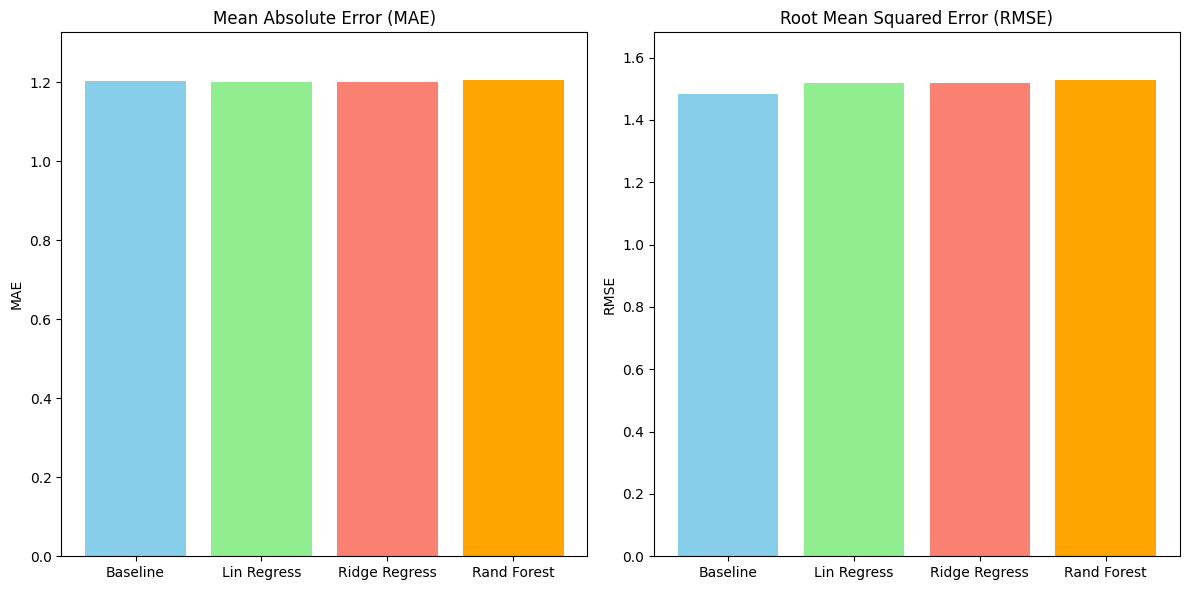

In [6]:
mae_values = [mean_absolute_error(y_test, y_pred_base),
              mean_absolute_error(y_test, y_pred_lin),
              mean_absolute_error(y_test, y_pred_ridge),
              mean_absolute_error(y_test, y_pred_rf)]

rmse_values = [np.sqrt(mean_squared_error(y_test, y_pred_base)),
               np.sqrt(mean_squared_error(y_test, y_pred_lin)),
               np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
               np.sqrt(mean_squared_error(y_test, y_pred_rf))]

# Model names
models_ = ['Baseline', 'Lin Regress', 'Ridge Regress','Rand Forest']

# Set up the figure and axes for MAE
plt.figure(figsize=(12, 6))

# Bar plot for MAE
plt.subplot(1, 2, 1)    # 1 row, 2 columns, 1st subplot 
plt.bar(models_, mae_values, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) + 0.1 * max(mae_values))

# Bar plot for RMSE
plt.subplot(1, 2, 2)
plt.bar(models_, rmse_values, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 0.1 * max(rmse_values))

# Display the plots
plt.tight_layout()
plt.show()


# INITIAL INFERENCES

Typically, the baseline model sets a minimal standard for the model’s performance, it gives a point of comparison. If a more sophisticated model like Linear regression, Ridge regression or Random forest can't significantly outperform this baseline, then there is a clear indication that the model isn't learning meaningful patterns in the data. To buttress this point further, the R^2 value for the complex models are negative, meaning the models performs worse than the baseline.

Perhaps I should try a more sophisticated and complex model like Neural network.

In [7]:
# USING NEURAL NETWORKS, a more complex model

import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for reproducibility
tf.random.set_seed(42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)  # Fit and transform X_train using the preprocessor defined earlier. More columns due to one-hot.
X_test_preprocessed = preprocessor.transform(X_test)    # Transform the test data using the preprocessor

# Build the neural network model
model = models.Sequential()     # Build the model layer by layer 
model.add(layers.InputLayer(input_shape=(X_train_preprocessed.shape[1],)))  # Input shape is the number of features/ columns
model.add(layers.Dense(64, activation='relu'))  # First hidden layer
model.add(layers.Dense(32, activation='relu'))  # Second hidden layer
model.add(layers.Dropout(0.3))  # Dropout layer regularizes the model to prevent overfitting. 30% of the neurons are dropped out during training
model.add(layers.Dense(1))  # Output layer for regression tasks. No activation function used because we want the model to predict the continuous target variable.

# Compiled the model using adam optimizer because it adapts the learning rate during training which helps both in covergence speed 
# and performance. Typically used over gradient descent methods.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to stop training when the validation loss is not decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model. 100 data run throughs, mini batches of 32 (average of SGD is calcuated), validation of 20% X_train
history = model.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, mae_nn = model.evaluate(X_test_preprocessed, y_test)
print("Neural Network MAE:", mae_nn)

# Make predictions
y_pred_nn = model.predict(X_test_preprocessed)

# Compare performance with other models
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("Neural Network RMSE:", rmse_nn)


2024-10-15 18:37:01.127720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 4.0964 - mae: 1.4811 - val_loss: 2.2136 - val_mae: 1.0001
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8311 - mae: 1.1874 - val_loss: 1.6662 - val_mae: 0.9472
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.1759 - mae: 1.1038 - val_loss: 1.5270 - val_mae: 0.9674
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2.1884 - mae: 1.1372 - val_loss: 1.4900 - val_mae: 0.9762
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0325 - mae: 1.1411 - val_loss: 1.4738 - val_mae: 0.9775
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.0766 - mae: 1.1497 - val_loss: 1.4655 - val_mae: 0.9721
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0027 - mae: 1.1125 - val_loss: 1.4583 - val_mae: 0.9714
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.0435 - mae: 1.1513 - val_loss: 1.4606 - val_mae: 0.9732
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - l

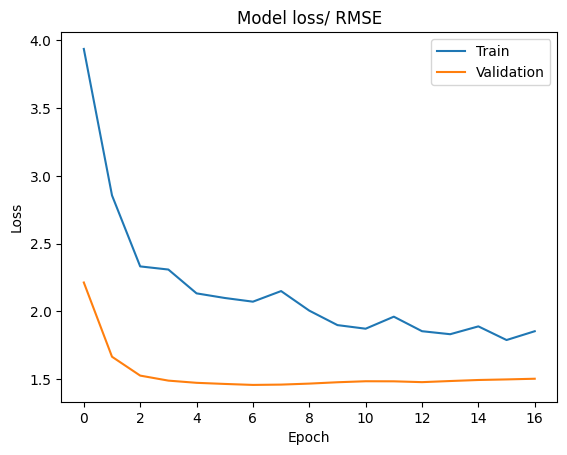

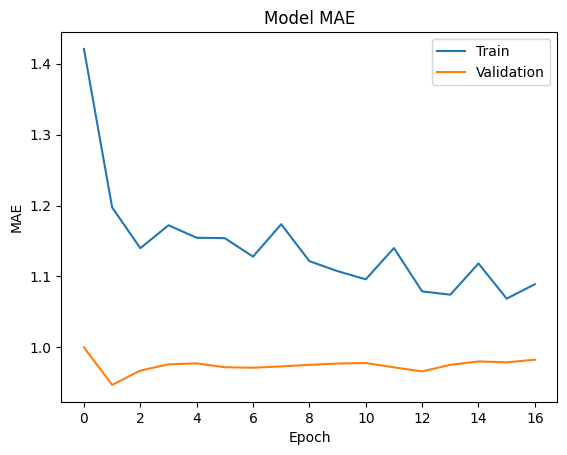

In [8]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss/ RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# BEFORE dropout regularization and early stoppage
Neural Network MAE: 1.5461108684539795

Neural Network RMSE: 2.0317000979512256

# AFTER dropout regularization and early stoppage
Neural Network MAE: 1.1685764789581299

Neural Network RMSE: 1.5001492054145107


Just a slight difference and perhaps not highly significant for the task at hand, however, I thought it was note-worthy.

In [ ]:
# Append the Neural Network's MAE and RMSE to the existing values
mae_values.append(mae_nn)
rmse_values.append(rmse_nn)

# Add Neural Network to the list of model names
models_.append('Neural Net')

# Set up the figure and axes for MAE and RMSE
plt.figure(figsize=(12, 6))

# Bar plot for MAE
plt.subplot(1, 2, 1)
plt.bar(models_, mae_values, color=['skyblue', 'gold', 'salmon', 'teal', 'lightgreen'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) + 0.1 * max(mae_values))


